# Lecture 4 - Jet images and transfer learning with CNNs

> A look at converting jets into images and classifying them with convolutional neural networks

## Learning objectives

* Understand how to convert jets into images
* Know what transfer learning is and it's advantages compared to training a neural network from scratch
* Understand the main steps needed to fine-tune a convolutional neural network

## References

* Chapter 1 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.
* [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) by G. Kasieczka et al.

## Setup

In [ ]:
# Uncomment and run this cell if using Colab, Kaggle etc
# %pip install fastai==2.6.0 datasets energyflow huggingface_hub

## Imports

In [38]:
import pandas as pd
from datasets import load_dataset
from energyflow.utils import (
    center_ptyphims,
    phi_fix,
    pixelate,
    ptyphims_from_p4s,
    reflect_ptyphims,
    rotate_ptyphims,
)
from fastai.vision.all import *
from huggingface_hub import from_pretrained_fastai
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from torch.utils.data import Dataset, TensorDataset
from torchvision.transforms import ToTensor
from scipy.interpolate import interp1d


In [23]:
import datasets

# Suppress logs to keep things tidy
datasets.logging.set_verbosity_error()

## Creating jet images

As we saw in lectures 1 and 2, there are various ways to represent jet data for neural networks. So far, we've focused on $N$-subjettiness features $\tau_N^{\beta}$, which represent jets in a _tabular_ format. Today, we'll examine another popular representation that treats _jets as 2D images_. An example from the top tagging review is shown below:

<center>
    <img alt="jet-images" caption="Jet images" src="images/jet-images.png" id="jet-images" width=800/>
</center>

But why consider images in the first place? The motivation here is partly historical: computer vision is where the deep learning revolution started in 2011, with [DanNet](https://people.idsia.ch/~juergen/DanNet-triggers-deep-CNN-revolution-2011.html) and [AlexNet](https://en.wikipedia.org/wiki/AlexNet) smashing the state-of-the-art on popular benchmarks. Both approaches were based on a type of architecture called a [_convolutional neural network_](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN), which is especially well suited for analysing images. In the next lecture we'll examine how CNNs work in detail, so today we'll focus on creating jet images and training a CNN with the high-level API of fastai.

To get started, let's take a look at how we can construct images from the 4-vectors associated with the consituents in a jet. We'll use the raw events from the [_Top Quark Tagging_ dataset](https://huggingface.co/datasets/dl4phys/top_tagging) in lecture 1, so let's download it and grab a sample of 10,000 events to play with:

In [4]:
raw_events = load_dataset("dl4phys/top_tagging", split="validation")
sample_df = raw_events.shuffle(seed=42).select(range(10_000)).to_pandas()
sample_df.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
0,130.172562,114.353065,-59.476486,18.188450,58.261734,56.383465,-6.442986,-13.184177,43.596382,37.914547,...,0.0,0.0,0.0,0.0,496.599976,418.331940,-202.994308,43.685955,2,1
1,144.244232,44.394894,71.800972,-116.962021,176.547729,61.791088,51.010948,-157.317657,134.554794,47.264194,...,0.0,0.0,0.0,0.0,1061.465576,240.111099,465.869263,-906.836731,2,1
2,164.264938,29.799849,-155.011093,45.458752,154.540726,34.444710,-140.643768,53.997475,102.357109,19.766624,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2,0
3,190.001175,-59.107372,-180.212479,11.411892,36.530270,-16.578011,-32.546757,0.582238,28.827248,-10.152600,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2,0
4,197.350937,-190.924622,-28.691614,-40.889717,65.894730,-63.749012,-9.580021,-13.652922,53.116070,-52.294987,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2,0


Here we've used the `shuffle()` and `select()` methods to create a random sample, and then converted the result to a pandas `DataFrame`. It's convenient to reshape the events so that instead of having 800 columns, we have 200 columns, where each column groups the 4-vectors of a constituent in a single array. We can do this by casting our `DataFrame` to NumPy and applying the `reshape()` method as follows:

In [5]:
# Reshape to size (num_jets, num_consituents, 4)
events = sample_df.iloc[:, :800].values.reshape(-1, 200, 4)
# Extract array of labels
labels = sample_df["is_signal_new"].values

events.shape, labels.shape

((10000, 200, 4), (10000,))

Now, each row in our `events` array corresponds to an array of shape `(num_constituents, 4)`. We can inspect one of these constituent 4-vectors as follows:

In [6]:
events[0][0]

array([130.17256 , 114.353065, -59.476486,  18.18845 ], dtype=float32)

> If we approximate the calorimeter resolution as 0.04×2.25◦
in rapidity vs azimuthal angle
a fat jet with radius parameter R = 0.8 can be covered with 40 × 40 pixels. Assuming a
pT threshold around 1 GeV, a typical QCD jet will feature around 40 constituents in this
jet image [22]. In Fig. 1 we show an individual calorimeter image from a top jet, as well
as averaged images of top jets and QCD jets, after some pre-processing. For both, signal
and background jets the center of the image is defined by the hardest object. Next, we
rotate the second-hardest object to 12 o’clock. Combined with a narrow pT -bin for the jets
this second jet develops a preferred distance from the center for the signal but not for the
QCD background. Finally, we reflect the third-largest object to the right side of the image,
where such a structure is really only visible for the 3-prong top signal. Note that this kind
of pre-processing is crucial for visualization, but not necessarily part of a tagger.

### Rotating to hadronic coordinates

Each of the 4-vectors in `events` is currently stored in Cartesian coordinates $(E, p_x, p_y, p_z)$. However, it is convenient to rotate the basis to _hadronic coordinates_ $(p_T, y, \phi, m)$, where:

$$ p_T = \sqrt{p_x^2 + p_y^2} \,, \quad y = \mathrm{arctanh}\, \frac{p_z}{E} \,, \quad \phi = \arctan \frac{p_y}{p_x}\,, \quad m = \sqrt{E - p_x^2 - p_y^2 - p_z^2}$$

Here $p_T$ denotes the transverse momentum, $y$ is the rapidity, $\phi$ the azimuthal angle, and $m$ the mass. Although we could implement these formulas directly in NumPy, we'll use the [EnergyFlow](https://energyflow.network/) library instead, which provides many utility functions for precisely these cases. To convert our 4-vectors to hadronic coordinates, we use the `ptyphims_from_p4s()` function:

In [7]:
events_hadronic = ptyphims_from_p4s(events, phi_ref="hardest", mass=True)

Here, the `phi_ref` argument specifies which $\phi$ value to use as reference within $\pm \pi$. The next step is to centre the collection of 4-vectors associated with each event. We can use the `center_ptyphims()` function to handle that for us:

In [8]:
events_centered = [center_ptyphims(event) for event in events_hadronic]

The final step is to reflect and rotate our events:

In [9]:
events_reflected_and_rotated = [
    reflect_ptyphims(rotate_ptyphims(event)) for event in events_centered
]

The final step is to create a jet image from an array of 4-vectors.  Here we can use the `pixelate()` function from EnergyFlow and we'll follow the precription from the top tagging review to create images of $40\times 40$ pixels. The end result is as follows:

In [10]:
images = [
    pixelate(
        event,
        npix=40,
        img_width=0.8,
        nb_chan=1,
        norm=False,
        charged_counts_only=False,
    )
    for event in events_reflected_and_rotated
]

images = np.array(images).reshape(len(images), 40, 40)

Now that we have our images, let's split them into those corresponding to the top-quarks and QCD background:

In [11]:
top_images = images[labels == 1]
qcd_images = images[labels == 0]

And now we can plot a few examples to see how the images look like:

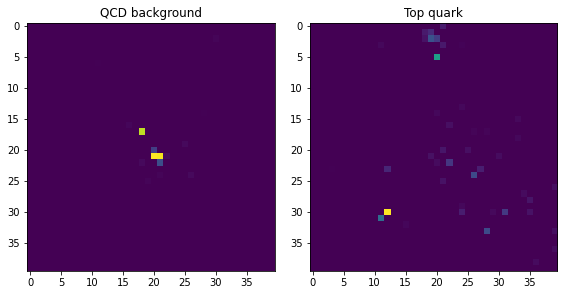

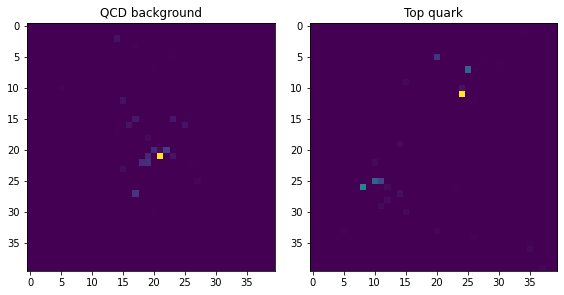

In [12]:
for i in range(2):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("QCD background")
    plt.imshow(qcd_images[i])
    plt.subplot(1, 2, 2)
    plt.title("Top quark")
    plt.imshow(top_images[i])
    plt.tight_layout()
    plt.show()

Notice how the background events are much more clustered around the centre, while the top-quark jets have multiple "prongs". We can see this more clearly by averaging the pixel values across all events:

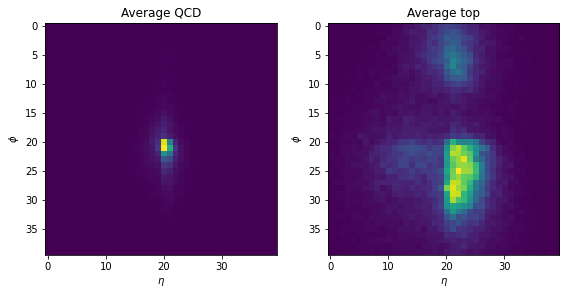

In [14]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.sum(qcd_images, axis=0))
plt.title("Average QCD")
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

plt.subplot(1, 2, 2)
plt.imshow(np.sum(top_images, axis=0))
plt.title("Average top")
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

plt.tight_layout()
plt.show()

Great, we now have a way to convert raw 4-vectors into jet images! For convenience, we've applied the above steps to the whole `top_tagging` dataset, so let's download it now from the [Hugging Face Hub](https://huggingface.co/datasets/dl4phys/top_tagging_images):

In [15]:
images_ds = load_dataset("dl4phys/top_tagging_images")
images_ds

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 404000
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1211000
    })
})

Here we now have three splits to work with, and we can access an individual image by indexing as follows:

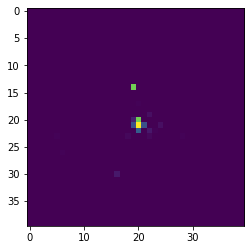

In [16]:
img = images_ds["train"][0]["image"]
plt.imshow(img);

Okay, this looks like a jet image - let's now take a look at converting them to PyTorch tensors that are suitable for training a neural net!

## From images to tensors

Now that we have a dataset of images, the next thing we need to do is convert them to PyTorch tensors and wrap them in a `DataLoader`. One way to do this is via `torchvision`'s `ToTensor` class, which converts a PIL image into a tensor as follows:

In [17]:
t = ToTensor()(img)
t.shape

torch.Size([1, 40, 40])

Here we can see that we now have a tensor of shape `(num_channels, height, width)`, where `num_channels` is 1 because we're dealing with black and white images, and `height` and `width` denote the number of pixels. To apply `ToTensor` to multiple images, we can use a list comprehension and `torch.cat()` to concatenate all the tensors as a single tensor:

In [47]:
x = torch.cat([ToTensor()(img) for img in images_ds["train"][:10]["image"]])
x.shape

torch.Size([10, 40, 40])

Now this isn't quite what we want because CNNs in PyTorch expect rank-4 tensors with a shape `(minibatch, channels, height, width)`, where `channels` refers to the number of color channels (e.g. RGB) of the image. In our case, the images are black and white, so we just need to reshape the tensor to insert a new dimension in the second position:

In [50]:
x = torch.cat([ToTensor()(img) for img in images_ds["train"][:10]["image"]])
x.unsqueeze_(dim=1)
x.shape

torch.Size([10, 1, 40, 40])

Great, we now have the image tensors in the right shape, so let write a simple `get_dataset()` helper function that applies this over a single training split:

In [18]:
def get_dataset(dataset, num_examples=None):
    if num_examples is not None:
        dataset = dataset.shuffle(seed=42).select(range(num_examples))

    x = torch.cat([ToTensor()(img) for img in dataset["image"]]).unsqueeze(1)
    y = torch.cat([torch.tensor(l).unsqueeze(0) for l in dataset["label"]])

    return TensorDataset(x, y)

Here we've also collected the labels in a single tensor and returned a `TensorDataset` object that we can iterate over:

In [70]:
# Lower the training size by setting num_examples=500_000 if Colab RAM explodes 💣
train_ds = get_dataset(images_ds["train"])
valid_ds = get_dataset(images_ds["validation"])

Now that we have the PyTorch datasets prepared, let's wrap them in dataloaders so we can generate minibatches during training:

In [71]:
train_dl = DataLoader(train_ds, bs=128, shuffle=True)
valid_dl = DataLoader(valid_ds, bs=128)
dls = DataLoaders(train_dl, valid_dl)

## Fine-tuning a pretrained CNN

Now that we have prepared our data and created dataloaders, we can train a CNN! Instead of training a CNN from scratch, we'll use a _pretrained model_ that has been already been trained to classify over a million photos in the famous [ImageNet dataset](https://www.image-net.org/). These models are called "pretrained" because their weights have already been optimized by training on another dataset. The layers in a pretrained model are well suited for detecting edges, colour gradient and so on, which allows us to train a new model with much less labelled data, and much faster. 

In practice, we replace the last layer of the pretrained model with a randomly initialized one that has the appropriate shape for the task at hand. For instance, ImageNet involves 1,000 different classes, so if we want to re-use the weights of a model trained on this dataset for a new set of classes, we'll need to resize the last layer. This last layer is often referred to as the _head_ of the network, with every layer before it belonging to the _body_.

This process of reusing the weights to solve a different task is called _transfer learning_, and now underpins much of the success that deep learning has achieved in computer vision, natural language processing, and audio. A cartoon of the process is shown below:

<center>
    <img alt="transfer" caption="Transfer learning" src="images/transfer-learning.png" id="transfer-learning" width=800/>
</center>

Anyway, enough jargon - let's train a model! As we did in lecture 1, we'll use the high-level API of fastai, which provides factory methods for various domains. Instead of a `tabular_learner()` we'll use the `vision_learner()`, which is designed for computer vision tasks:

In [72]:
learn = vision_learner(
    dls,
    resnet34,
    metrics=[accuracy, RocAucBinary()],
    n_in=1,
    n_out=2,
    normalize=False,
    loss_func=F.cross_entropy,
)

Here we've provided the dataloaders and specified `resnet34` as the name of the pretrained model we wish to initialise with. ResNets are a popular type of CNN that we might cover in a future lesson, but for now it is enough to know that they are great for most computer vision tasks. Now, because we're using custom dataloaders instead of the factory methods provided by fastai, we need to specify that our model should run on a GPU instead of CPU (the default). We can do that by tapping into the model and selecting the desired device name with PyTorch's `to()` method:

In [73]:
learn.model.to("cuda");

Now that our model is on the GPU, we can follow the same steps we've done in previous lectures. First we find a good learning rate:

SuggestedLRs(valley=0.0010000000474974513)

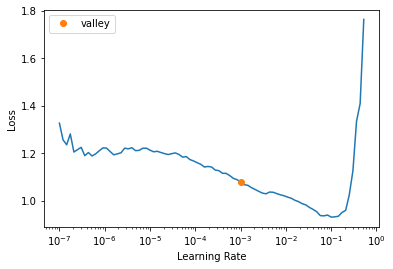

In [69]:
learn.lr_find()

And finally we can train the model:

In [ ]:
learn.fine_tune(3, 3e-3)

Note that this time we didn't call `fit()` or `fit_one_cycle()` as we've done in previous lectures. That's because we're starting with a pretrained model whose weights we "fine-tuned" to the new dataset of jet images. This process involves some tricks which is why it is called `fine_tune()`. Anyway, we've now got a model that scores pretty well on the validation set. Let's compute the same metrics we did in lecture 1, but now on the test set:

In [ ]:
def compute_metrics(learn, test_ds):
    test_dl = learn.dls.test_dl(test_items=test_ds)
    preds, targs = learn.get_preds(dl=test_dl)
    fpr, tpr, _ = roc_curve(y_true=targs, y_score=preds[:, 1])
    acc_test = accuracy_score(targs, preds.argmax(dim=-1))
    auc_test = auc(fpr, tpr)
    background_eff = interp1d(tpr, fpr)
    background_eff_at_30 = background_eff(0.3)

    print(f"Accuracy: {acc_test:.4f}")
    print(f"AUC: {auc_test:.4f}")
    print(
        f"Backround rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}"
    )
    return fpr, tpr

In [ ]:
_, _ = compute_metrics(learn, images_ds["test"])

Comparing our results against those in the top tagging review, shows that our CNN is getting quite competitive results with the state-of-the-art!

<center>
    <img alt="transfer" caption="Transfer learning" src="images/top-tagging-scores.png" id="transfer-learning" width=800/>
</center>